In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import progressbar

import os

from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.metrics.pairwise import linear_kernel

from surprise import dump

from sklearn.decomposition import PCA

from sklearn.metrics.pairwise import cosine_similarity
from math import floor

from surprise import SVD, accuracy

from heapq import nlargest

import joblib
from surprise.dump import dump, load
import pickle

In [3]:
articles_metadata = pd.read_csv('data/articles_metadata.csv')
pickle = pd.read_pickle('data/articles_embeddings.pickle')

In [4]:
articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [5]:
articles_metadata.describe()

,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000000,364047.000000,3.640470e+05,364047.0,364047.000000
mean,182023.000000,283.108239,1.474070e+12,0.0,190.897727
std,105091.461061,136.723470,4.293038e+10,0.0,59.502766
min,0.000000,0.000000,1.159356e+12,0.0,0.000000
25%,91011.500000,199.000000,1.444925e+12,0.0,159.000000
50%,182023.000000,301.000000,1.489422e+12,0.0,186.000000
75%,273034.500000,399.000000,1.509891e+12,0.0,218.000000
max,364046.000000,460.000000,1.520943e+12,0.0,6690.000000


In [6]:
articles_metadata.shape

(364047, 5)

In [7]:
articles_metadata.isna().mean()

article_id       0.0
category_id      0.0
created_at_ts    0.0
publisher_id     0.0
words_count      0.0
dtype: float64

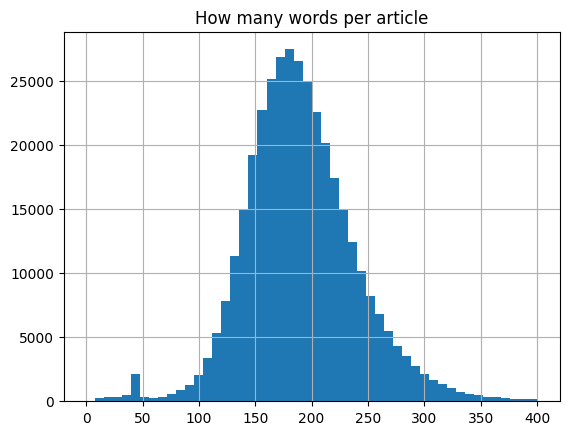

In [8]:
articles_metadata.words_count.hist(bins=50, range=(0,400))
plt.title('How many words per article');

## Nombre de clics

In [9]:
clicks_hour_000 = pd.read_csv('data/clicks/clicks_hour_000.csv')  
clicks_hour_000

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


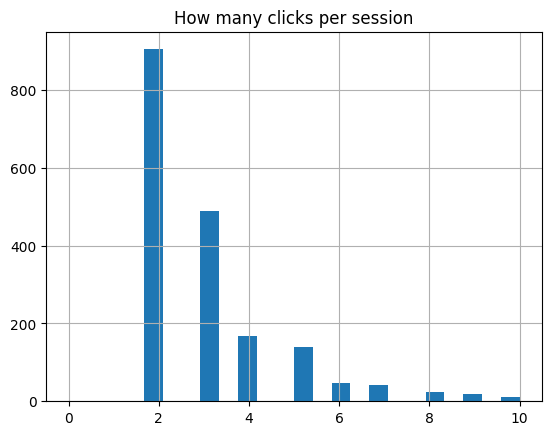

In [10]:
clicks_hour_000.session_size.hist(bins=24, range=(0,10))
plt.title('How many clicks per session');

In [11]:
clicks_hour_000.loc[clicks_hour_000.user_id == 0]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2


In [12]:
clicks_hour_000.loc[clicks_hour_000.session_id == 1506828979881443]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1
1882,706,1506828979881443,1506828979000,3,68866,1506829125732,4,3,2,1,25,1


In [13]:
clicks_hour_000

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


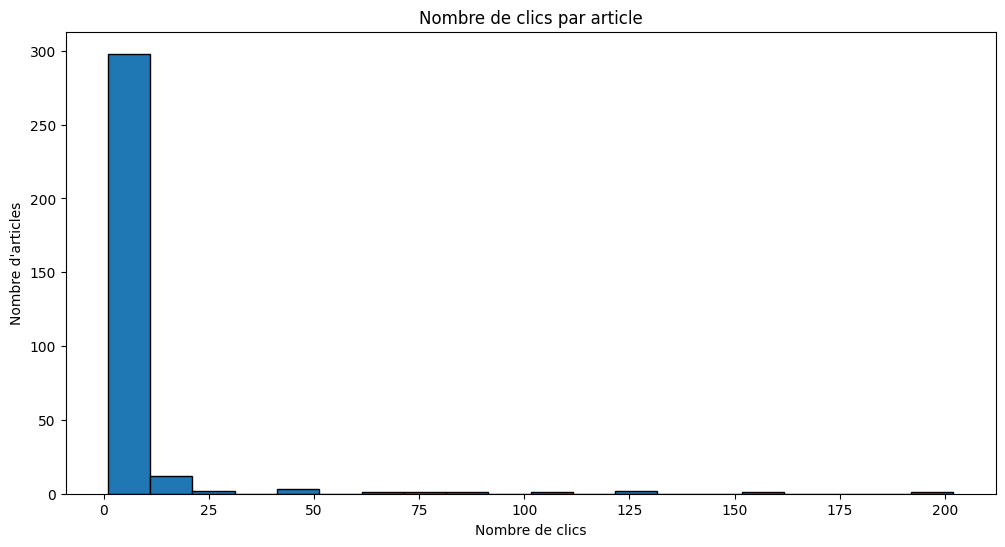

In [14]:
# Charger les données 'clicks_hour_000'
clicks_hour_000 = pd.read_csv('data/clicks/clicks_hour_000.csv')

# Regrouper les données par 'click_article_id' et compter le nombre de clics par article
clicks_per_article = clicks_hour_000.groupby('click_article_id')['click_article_id'].count()

# Créer un histogramme
plt.figure(figsize=(12, 6))
plt.hist(clicks_per_article, bins=20, edgecolor='k')
plt.title('Nombre de clics par article')
plt.xlabel('Nombre de clics')
plt.ylabel('Nombre d\'articles')
plt.show()

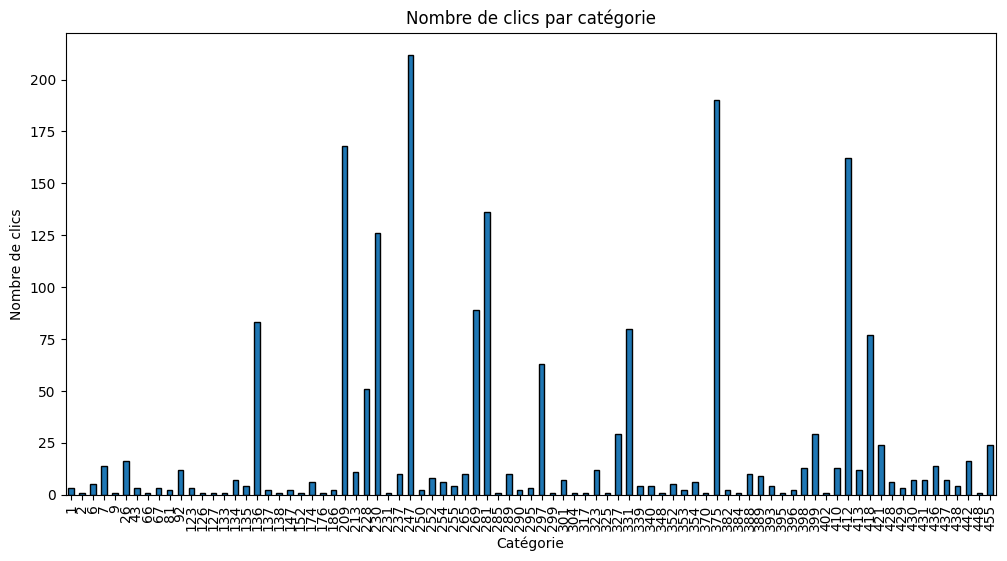

In [15]:
# Fusionner les données de clics avec les données d'articles pour obtenir la catégorie de chaque article
clicks_with_categories = clicks_hour_000.merge(articles_metadata, left_on='click_article_id', right_on='article_id')

# Regrouper les données par catégorie et compter le nombre de clics par catégorie
clicks_per_category = clicks_with_categories.groupby('category_id')['click_article_id'].count()

# Créer un graphique à barres pour afficher le nombre de clics par catégorie
plt.figure(figsize=(12, 6))
clicks_per_category.plot(kind='bar', edgecolor='k')
plt.title('Nombre de clics par catégorie')
plt.xlabel('Catégorie')
plt.ylabel('Nombre de clics')
plt.show()

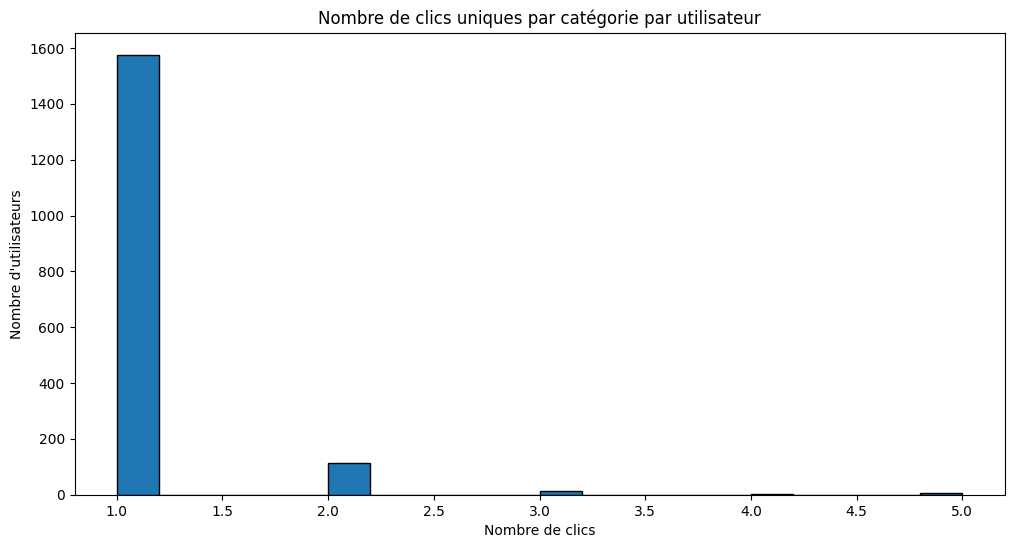

In [16]:
# Fusionner les données de clics avec les données d'articles pour obtenir la catégorie de chaque article
clicks_with_categories = clicks_hour_000.merge(articles_metadata, left_on='click_article_id', right_on='article_id')

# Supprimer les duplications de clics pour chaque utilisateur et chaque article
unique_clicks_per_user = clicks_with_categories.drop_duplicates(subset=['user_id', 'click_article_id'])

# Regrouper les données par utilisateur et catégorie, puis compter le nombre de clics uniques par paire utilisateur-catégorie
clicks_per_user_category = unique_clicks_per_user.groupby(['user_id', 'category_id']).size().reset_index(name='click_count')

# Créer un histogramme du nombre de clics par catégorie
plt.figure(figsize=(12, 6))
plt.hist(clicks_per_user_category['click_count'], bins=20, edgecolor='k')
plt.title('Nombre de clics uniques par catégorie par utilisateur')
plt.xlabel('Nombre de clics')
plt.ylabel('Nombre d\'utilisateurs')
plt.show()

Traitement des fichiers CSV contenant des données de clics.

1. `%%time`: Cette ligne est une magie Jupyter qui mesure le temps d'exécution du code contenu dans la cellule. Elle est utile pour évaluer la performance du code.

2. Vérification de l'existence du fichier 'clicks.csv':
   - Il commence par vérifier si le fichier 'clicks.csv' existe dans le répertoire actuel.

3. Si le fichier 'clicks.csv' n'existe pas :
   - Il crée une liste vide `clicks_path` pour stocker les chemins des fichiers CSV de clics.
   - Il spécifie le répertoire 'data/clicks' où les fichiers CSV sont recherchés.
   - Il recherche tous les fichiers CSV se terminant par ".csv" dans ce répertoire et les ajoute à la liste `clicks_path`.
   - Il affiche le nombre de fichiers CSV trouvés.
   - Il initialise une liste vide `_li` pour stocker les DataFrames individuels extraits des fichiers CSV.

4. Lecture et concaténation des fichiers CSV :
   - Il parcourt chaque fichier CSV dans la liste `clicks_path`, lit son contenu en tant que DataFrame et l'ajoute à la liste `_li`.
   - Ensuite, il utilise la fonction `pd.concat` pour concaténer tous les DataFrames de la liste `_li` en un seul DataFrame appelé 'clicks'.

5. Enregistrement du DataFrame dans 'clicks.csv' :
   - Une fois tous les fichiers CSV concaténés, il enregistre le DataFrame 'clicks' dans un fichier 'clicks.csv' pour une utilisation future.

6. Si le fichier 'clicks.csv' existe déjà :
   - Il lit simplement le fichier 'clicks.csv' dans un DataFrame 'clicks'.

7. Affichage du DataFrame 'clicks':
   - Enfin, le code affiche le DataFrame 'clicks', qu'il s'agisse du DataFrame nouvellement créé ou de celui lu à partir du fichier 'clicks.csv'.

Cela permet de charger et de fusionner plusieurs fichiers CSV de clics en un seul DataFrame 'clicks', ce qui est utile pour l'analyse ultérieure des données de clics. Il mesure également le temps d'exécution de cette opération pour évaluer sa performance.

In [17]:
%%time

# Vérifier si le fichier 'clicks.csv' existe
if not os.path.exists('clicks.csv'):
    # Définir la liste des chemins des fichiers 'clicks' et le répertoire 'data/clicks'
    clicks_path = []
    clicks_dir = "data/clicks"

    # Ajouter les chemins des fichiers CSV se terminant par ".csv" dans la liste
    clicks_path = clicks_path + sorted(
            [
                os.path.join(clicks_dir, fname)
                for fname in os.listdir(clicks_dir)
                if fname.endswith(".csv")
            ]
        )
    print("Nombre de fichiers CSV de clics :", len(clicks_path))

    # Initialiser une liste vide '_li' pour stocker les DataFrames
    _li = []

    # Lire chaque fichier CSV, le stocker dans un DataFrame, et l'ajouter à la liste '_li'
    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        _li.append(df)

    # Concaténer tous les DataFrames de la liste '_li' en un seul DataFrame 'clicks'
    clicks = pd.concat(_li, axis=0, ignore_index=True)

    # Enregistrer le DataFrame 'clicks' dans un fichier 'clicks.csv'
    clicks.to_csv('clicks.csv')
else:
    # Si le fichier 'clicks.csv' existe déjà, le lire dans un DataFrame 'clicks'
    clicks = pd.read_csv('clicks.csv')

# Afficher le DataFrame 'clicks'
clicks

CPU times: total: 2.22 s
Wall time: 2.36 s


,Unnamed: 0,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


## Embeding

In [18]:
pickle.shape

(364047, 250)

In [19]:
# Création d'un DataFrame à partir d'un tableau Numpy (pickle)
# Le DataFrame sera utilisé pour stocker des informations, par exemple, des embeddings d'articles.
# Le tableau Numpy 'pickle' doit contenir les données à convertir en DataFrame.
articles_emb = pd.DataFrame(pickle, columns=["embedding_" + str(i) for i in range(pickle.shape[1])])

# Affichage des premières lignes du DataFrame
# Cela permet de voir un aperçu des données stockées dans le DataFrame nouvellement créé.
# Cela peut être utile pour vérifier que les données ont été correctement chargées.
articles_emb.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292


In [20]:
# Création d'un objet PCA avec 70 composantes
pca = PCA(n_components=70)

# Ajustement du modèle PCA aux données d'embedding des articles (articles_emb)
# Le modèle PCA est utilisé pour réduire la dimensionnalité des données.
pca.fit(articles_emb)

# Transformation des données d'embedding des articles en utilisant le modèle PCA
# Cela crée une nouvelle représentation des données en utilisant seulement les 70 composantes principales.
articles_emb_pca = pca.transform(articles_emb)

`articles_emb` est vcolumineux donc on utilise l'analyse en composantes principales (PCA) pour réduire la dimensionnalité des données stockées dans le DataFrame `articles_emb`

In [21]:
# Calcul de la somme des ratios de variance expliquée par les composantes principales
explained_variance_sum = sum(pca.explained_variance_ratio_)

La valeur de 0.9773071179919858  indique que les 70 premières composantes principales retiennent environ 97,73 % de la variance totale des données d'origine. En d'autres termes, en utilisant seulement ces 70 composantes principales, nous conservons la grande majorité de l'information essentielle contenue dans les données d'origine, tout en réduisant considérablement leur dimensionnalité.

Cela signifie que ces 70 composantes principales sont suffisantes pour représenter les données de manière plus compacte, tout en préservant la plupart des informations importantes, ce qui peut être utile pour l'analyse et la visualisation des données, tout en réduisant la complexité.

## user interactions

In [22]:
# Sélection des colonnes pertinentes dans le DataFrame 'clicks'
clicks = clicks[['user_id', 'session_id', 'session_size', 'click_article_id']]

# Affichage des premières lignes du DataFrame résultant
clicks.head()

,user_id,session_id,session_size,click_article_id
0,0,1506825423271737,2,157541
1,0,1506825423271737,2,68866
2,1,1506825426267738,2,235840
3,1,1506825426267738,2,96663
4,2,1506825435299739,2,119592


In [23]:
# Sauvegarder le DataFrame au format CSV
clicks.to_csv('data/clicks_data.csv', index=False)  # L'argument index=False évite d'enregistrer l'index du DataFrame

In [24]:
# Regroupement des interactions des utilisateurs par 'user_id' et agrégation
users_interactions = clicks.groupby('user_id').agg({'click_article_id': lambda x: list(x)})

# Affichage des premières lignes du DataFrame résultant
users_interactions.head()

,click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."


 réorganiser les données des clics en regroupant les interactions des utilisateurs avec des articles dans une structure de données plus pratique. La variable ``users_interactions`` contient maintenant une liste des articles cliqués par chaque utilisateur, ce qui peut faciliter l'analyse des activités des utilisateurs et des articles. 

# Content Based

In [25]:
def contentBasedRecommendArticle(articles, clicks, user_id, n):
    # La fonction recommande des articles en se basant sur le contenu (content-based filtering).

    # Récupération des articles lus par l'utilisateur
    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    # Vérification si l'utilisateur a lu des articles
    if len(articles_read) == 0:
        return "L'utilisateur n'a lu aucun article"

    # Extraction des embeddings des articles lus par l'utilisateur
    articles_read_embedding = articles.loc[articles_read]

    # Suppression des articles lus de la liste des articles disponibles
    articles = articles.drop(articles_read)

    # Calcul de la similarité entre les embeddings des articles lus et les autres articles
    matrix = cosine_similarity(articles_read_embedding, articles)

    # Initialisation d'une liste pour stocker les recommandations
    rec = []

    # Boucle pour recommander 'n' articles
    for i in range(n):
        # Trouver les coordonnées (indices) du maximum de similarité dans la matrice
        coord_x = floor(np.argmax(matrix) / matrix.shape[1])
        coord_y = np.argmax(matrix) % matrix.shape[1]

        # Ajout de l'indice de l'article recommandé à la liste
        rec.append(int(articles.index[coord_y]))

        # Mise à zéro de la valeur de similarité pour éviter de recommander le même article
        matrix[coord_x][coord_y] = 0

    # Retourne la liste des articles recommandés
    return rec

Cette fonction met en œuvre un système de recommandation de contenu en utilisant la similarité cosinus entre les embeddings des articles lus et les articles disponibles pour recommander les articles les plus similaires à l'utilisateur. Le nombre d'articles recommandés est défini par le paramètre n.

In [26]:
# Création d'un DataFrame à partir des données transformées avec PCA (articles_emb_pca)
articles_emb_pca_df = pd.DataFrame(articles_emb_pca)

In [27]:
articles_emb_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-2.176780,-1.316907,-1.029063,0.901912,-1.809541,2.064705,1.221914,0.024429,0.927229,0.669826,...,0.230861,-0.100415,0.048567,0.060868,-0.317857,0.523098,0.116547,-0.419833,0.001515,0.071231
1,-1.735178,0.489874,3.268562,0.087859,1.473058,0.932723,-1.841620,0.881805,-0.207195,-0.816819,...,-0.102117,0.084023,-0.034985,0.417478,0.300032,-0.107192,-0.142815,0.195200,-0.175058,0.090926
2,-0.912691,-2.089351,1.865861,-1.202521,2.530595,0.521966,-0.224344,-1.479932,-0.191864,-1.356812,...,0.104950,0.102567,0.192590,0.219754,0.143101,-0.140618,0.141144,-0.141193,0.070313,0.273462
3,1.096562,0.212930,4.183520,-0.649562,-0.130873,-1.126545,-1.063995,0.662892,0.348148,-1.463903,...,0.179801,-0.028663,-0.371410,-0.104420,0.365908,0.290965,0.356213,-0.051597,-0.058510,-0.289961
4,0.193782,-0.263961,1.896587,-1.834345,1.270370,1.723293,-0.328995,-0.283797,-0.659789,-1.223755,...,0.448702,-0.348884,0.222809,-0.083341,0.405584,-0.123353,0.380839,0.100890,0.157479,-0.134766


In [28]:
# Sauvegarder le DataFrame au format CSV
articles_emb_pca_df.to_csv('data/articles_emb_pca_data.csv', index=False)  # L'argument index=False évite d'enregistrer l'index du DataFrame


In [29]:
# Appel de la fonction 'contentBasedRecommendArticle' pour recommander des articles
recommendation = contentBasedRecommendArticle(articles_emb_pca_df, clicks, 5, 5)

# Affichage des recommandations
print(recommendation)

[157015, 284603, 62627, 62630, 224354]


# Collaborative filtering

 le modèle de recommandation collaborative SVD est une technique puissante pour les systèmes de recommandation qui se base sur la factorisation de la matrice utilisateur-article pour prédire les évaluations et fournir des recommandations personnalisées. Il est largement utilisé dans l'industrie et continue d'être un choix populaire pour de nombreux systèmes de recommandation en ligne.

In [30]:
def calculRatingByClick(clicks):
    # Calcul des tailles de session pour chaque utilisateur et chaque article
    count_user_article_size = clicks.groupby(['user_id', 'click_article_id']).agg(user_article_size=('session_size', 'sum'))
    
    # Calcul de la taille totale de la session pour chaque utilisateur
    count_user_total_size = clicks.groupby(['user_id']).agg(user_total_size=('session_size', 'sum'))

    # Combinaison des informations sur la taille de session des utilisateurs et des articles
    # pour calculer les évaluations (ratings)
    ratings = count_user_article_size.join(count_user_total_size, on='user_id')
    
    # Calcul des évaluations en divisant la taille de la session de l'utilisateur pour un article donné
    # par la taille totale de la session de l'utilisateur.
    ratings['Rating'] = ratings['user_article_size'] / ratings['user_total_size']

    # Réinitialisation de l'index du DataFrame
    ratings = ratings.reset_index()

    # Suppression des colonnes inutiles (user_article_size et user_total_size)
    ratings = ratings.drop(['user_article_size', 'user_total_size'], axis=1)

    # Renommage de la colonne 'click_article_id' en 'article_id'
    ratings = ratings.rename(columns={'click_article_id': 'article_id'})

    return ratings

Cette fonction calcule les évaluations des utilisateurs en fonction de leurs interactions avec des articles, en mesurant la proportion de la taille de session consacrée à un article par rapport à la taille totale de la session de l'utilisateur.

In [31]:
# Appel de la fonction 'calculRatingByClick' pour calculer les évaluations
ratings = calculRatingByClick(clicks)

# Affichage des premières lignes du DataFrame résultant
ratings.head()

,user_id,article_id,Rating
0,0,68866,0.125
1,0,87205,0.125
2,0,87224,0.125
3,0,96755,0.125
4,0,157541,0.125


In [32]:
# Création d'un objet Reader pour spécifier l'échelle de notation des évaluations
reader = Reader(rating_scale=(0, 1))

# Chargement des données à partir du DataFrame 'ratings' en utilisant le Reader
# Les données sont échantillonnées à 10% (frac=0.1) pour réduire la taille du jeu de données
data = Dataset.load_from_df(ratings.sample(frac=0.1, random_state=42), reader=reader)

# Définition de la grille de recherche de paramètres pour le modèle SVD
param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [10, 20, 50],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.04, 0.1]
}

# Création d'un objet GridSearchCV pour trouver les paramètres optimaux du modèle SVD
# Les métriques à évaluer sont RMSE et MAE, et la validation croisée est effectuée avec 3 partitions
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Exécution de la recherche des paramètres optimaux sur les données
gs.fit(data)

Ici on utilise la bibliothèque Surprise pour effectuer une recherche de grille afin de trouver les meilleurs paramètres du modèle de recommandation collaborative SVD. Cette méthode permet d'optimiser les performances du modèle en ajustant ses paramètres en fonction des données d'évaluation.

In [33]:
# Récupération des paramètres optimaux et de leurs performances (RMSE et MAE)
best_rmse = gs.best_score['rmse']
best_mae = gs.best_score['mae']

# Affichage des paramètres optimaux et de leurs performances
best_rmse, best_mae

(0.11423538505739457, 0.07776233061736487)

En obtenant ces valeurs, on peut évaluer à quel point le modèle SVD est performant en utilisant ces métriques d'évaluation. Plus précisément, il nous permet de savoir à quel point les prédictions du modèle correspondent aux données réelles, en termes d'erreurs moyennes (RMSE) et d'écarts moyens (MAE). Un modèle avec un RMSE et un MAE plus bas est généralement considéré comme meilleur.

In [34]:
# Chargement des données à partir du DataFrame 'ratings' en utilisant le Reader spécifié
data = Dataset.load_from_df(ratings, reader=reader)

# Création d'un ensemble d'entraînement complet à partir des données
trainset = data.build_full_trainset()

# Sélection du meilleur modèle SVD à partir de la recherche de paramètres
model_SVD = gs.best_estimator['rmse']

# Entraînement du modèle SVD sur l'ensemble d'entraînement complet
model_SVD.fit(trainset)

Ici on charge les données d'évaluation à partir du DataFrame ratings, crée un trainset, on récupère le meilleur modèle SVD configuré avec les paramètres optimaux trouvés lors de la recherche de grille, puis entraîne ce modèle sur le trainset. Le modèle entraîné sera utilisé pour faire des prédictions sur des évaluations manquantes, ce qui permettra de recommander des articles aux utilisateurs en fonction de leur historique d'évaluations

In [ ]:
'''# Sauvegarder le modèle SVD
joblib.dump(model_SVD, 'model_SVD.pkl')'''

In [38]:
'''from surprise.dump import dump, load

# Save the Surprise SVD model
dump('model/model_SVD.pkl', predictions=None, algo=model_SVD)'''

In [60]:


# Save the model
with open('model/model_SVD_pickle.pkl', 'wb') as f:
    pickle.dump(model_SVD, f)

In [43]:
# Utilisation du modèle SVD pour effectuer une prédiction
# '165' est l'ID de l'utilisateur et '285939' est l'ID de l'article à prédire
# verbose=True permet d'afficher des informations de débogage
prediction = model_SVD.predict(165, 285939, verbose=True)

user: 165        item: 285939     r_ui = None   est = 0.33   {'was_impossible': False}


In [10]:
def collaborativeFilteringRecommendArticle(model, articles, clicks, user_id, n=5):
    # Recommandation d'articles en utilisant la méthode de filtrage collaboratif (collaborative filtering).

    # Création d'une liste 'index' contenant les indices des articles disponibles
    index = list(articles.index)

    # Récupération des articles lus par l'utilisateur ayant 'user_id'
    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    # Suppression des articles lus de la liste des articles disponibles
    for ele in articles_read:
        if ele in index:
            index.remove(ele)

    # Initialisation d'un dictionnaire pour stocker les prédictions
    results = dict()

    # Boucle pour prédire et recommander des articles
    for i in index:
        # Prédiction de la note (estimation) que l'utilisateur donnerait à l'article
        pred = model.predict(user_id, i)
        
        # Stockage de la prédiction dans le dictionnaire avec l'ID de l'article comme clé
        results[pred.iid] = pred.est

    # Sélection des 'n' articles les mieux recommandés en utilisant nlargest
    # avec la fonction de tri basée sur les estimations
    return nlargest(n, results, key=results.get)

Cette fonction de filtrage collaboratif recommande les articles non lus à un utilisateur en utilisant le modèle SVD pour prédire les évaluations. Elle supprime les articles déjà lus par l'utilisateur de la liste des recommandations et renvoie les n articles les mieux notés en fonction des estimations du modèle.

In [53]:
# Appel de la fonction 'collaborativeFilteringRecommendArticle' pour recommander des articles à un utilisateur
test_cf = collaborativeFilteringRecommendArticle(model_SVD, articles_emb, clicks, 3, 5)

# Affichage des recommandations
print(test_cf)

[289003, 186070, 283009, 277107, 50644]


On peut voir les différents articles recommandé. 

In [7]:
# Pour charger le modèle plus tard
#loaded_model_SVD = joblib.load('model_SVD.pkl')
#_ , loaded_model_SVD = load('model/model_SVD.pkl')

with open('model/model_SVD_pickle.pkl', 'rb') as f:
    loaded_model_SVD = pickle.load(f)
articles_emb_data = pd.read_csv('data/articles_emb_data.csv')
clicks_data = pd.read_csv('data/clicks_data.csv')

In [ ]:
print(loaded_model_SVD)

In [8]:
# Make predictions
user_id = 165
item_id = 285939
prediction = loaded_model_SVD.predict(user_id, item_id, verbose=True)

user: 165        item: 285939     r_ui = None   est = 0.33   {'was_impossible': False}


In [11]:
# Appel de la fonction 'collaborativeFilteringRecommendArticle' pour recommander des articles à un utilisateur
test_cf = collaborativeFilteringRecommendArticle(loaded_model_SVD, articles_emb_data, clicks_data, 3, 5)

# Affichage des recommandations
print(test_cf)

[289003, 74457, 283009, 186070, 74501]


In [20]:
from scipy.spatial import distance
import json


def contentBasedRecommendArticle2(articles, clicks, user_id, n):
    # La fonction recommande des articles en se basant sur le contenu (content-based filtering).

    # Récupération des articles lus par l'utilisateur
    articles_read = clicks[clicks['user_id'] == user_id]['click_article_id'].tolist()

    # Vérification si l'utilisateur a lu des articles
    if len(articles_read) == 0:
        return "L'utilisateur n'a lu aucun article"

    # Extraction des embeddings des articles lus par l'utilisateur
    articles_read_embedding = articles.loc[articles_read]

    # Suppression des articles lus de la liste des articles disponibles
    articles = articles.drop(articles_read)


    matrix = distance.cdist(articles_read_embedding, articles, "cosine")[0]

    result = np.argsort(matrix)[1:6]
    result = result.tolist()

    recommandations = json.dumps(result)
    
    
    return recommandations

In [21]:
# Appel de la fonction 'collaborativeFilteringRecommendArticle' pour recommander des articles à un utilisateur
test_cf = contentBasedRecommendArticle2(articles_emb_data, clicks_data, 3, 5)

# Affichage des recommandations
print(test_cf)

[220405, 234997, 247699, 236316, 232453]


In [24]:
articles_emb_data.head(10)

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_240,embedding_241,embedding_242,embedding_243,embedding_244,embedding_245,embedding_246,embedding_247,embedding_248,embedding_249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320786,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292
5,-0.724885,-0.974610,0.114743,0.135984,-0.059124,0.139286,-0.720786,-0.311302,-0.543600,0.613687,...,0.430414,0.492010,0.650828,-0.627942,0.562439,0.792561,-0.877570,-0.002212,0.426586,-0.065801
6,-0.161707,-0.967413,0.637266,0.249817,0.471958,0.391854,-0.815684,-0.296389,-0.804284,-0.513054,...,0.020420,0.509749,0.559321,-0.794207,-0.366995,0.616669,-0.626267,-0.452933,0.166825,-0.728330
7,-0.104534,-0.965899,0.800449,0.351384,-0.389743,0.421198,-0.600862,-0.021568,-0.265164,-0.061443,...,0.124667,0.545793,0.372644,-0.510156,-0.217100,0.676449,-0.852480,0.198584,0.243181,-0.596663
8,-0.417274,-0.977311,0.054967,0.351192,0.049049,-0.460898,-0.443555,0.154505,0.018687,0.378063,...,0.601953,0.756593,-0.257438,-0.130827,-0.061200,0.438138,-0.719562,-0.744506,0.163397,-0.499539
9,-0.348442,-0.966953,0.682574,-0.400164,0.646688,0.085186,-0.636333,-0.351318,-0.542529,0.198339,...,0.220249,0.025085,0.510007,-0.832078,-0.555277,0.317832,-0.576926,-0.671720,0.304353,-0.721567


In [25]:
clicks_data.head()

,user_id,session_id,session_size,click_article_id
0,0,1506825423271737,2,157541
1,0,1506825423271737,2,68866
2,1,1506825426267738,2,235840
3,1,1506825426267738,2,96663
4,2,1506825435299739,2,119592


In [26]:
# Assume clicks_data is your DataFrame
user_ids_to_include = [0, 1, 2]

# Use the isin method to filter rows with the specified user_ids
clicks_data_sample = clicks_data[clicks_data['user_id'].isin(user_ids_to_include)]

In [27]:
clicks_data_sample.head()

,user_id,session_id,session_size,click_article_id
0,0,1506825423271737,2,157541
1,0,1506825423271737,2,68866
2,1,1506825426267738,2,235840
3,1,1506825426267738,2,96663
4,2,1506825435299739,2,119592


In [28]:
# Extraction des embeddings des articles lus par l'utilisateur
articles_read_embedding = articles_emb_data.loc[clicks_data_sample]

ValueError: Cannot index with multidimensional key

In [33]:
# Assuming you want to initialize an empty DataFrame with the specified columns
columns = ['user_id', 'session_id', 'session_size', 'click_article_id']

# Initialize the DataFrame
articles_read = pd.DataFrame(columns=columns)

for i in user_ids_to_include : 
    
    # Récupération des articles lus par l'utilisateur
    articles_read = articles_read.append(clicks_data_sample[clicks_data_sample['user_id'] == i]['click_article_id'].tolist())

    # Vérification si l'utilisateur a lu des articles
    if len(articles_read) == 0:
        print("L'utilisateur n'a lu aucun article")

    # Extraction des embeddings des articles lus par l'utilisateur
    articles_read_embedding = articles_emb_data.loc[articles_read]
    

C:\Users\Jupiter\AppData\Local\Temp\ipykernel_19244\923229378.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  articles_read = articles_read.append(clicks_data_sample[clicks_data_sample['user_id'] == i]['click_article_id'].tolist())


ValueError: Cannot index with multidimensional key